In [1]:
# установка необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

# вывод графика и сохранение в ноутбуке
%matplotlib inline

In [ ]:
tf.__version__

'2.6.4'

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
N_CLASSES = 9

In [7]:
# загрузка обучающего и валидационного датафреймов из csv-файлов
train_df = pd.read_csv('train_df.csv', index_col = 0) 
test_df = pd.read_csv('test_df.csv', index_col = 0)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40037 entries, 46357 to 14269
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  40037 non-null  object
 1   emotion     40037 non-null  object
dtypes: object(2)
memory usage: 938.4+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 2 to 50040
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10009 non-null  object
 1   emotion     10009 non-null  object
dtypes: object(2)
memory usage: 234.6+ KB


In [8]:
# создание обучающего и валидационного набора данных в ввиде конвейеров ввода
train_ds = tf.data.Dataset.from_tensor_slices(list(train_df.image_path))
val_ds = tf.data.Dataset.from_tensor_slices(list(test_df.image_path))

In [9]:
# создание словаря эмоций из файла
def load_dict_from_file(path):
    f = open(path, 'r')
    data=f.read()
    f.close()
    return eval(data)

emotion_mapping = load_dict_from_file('dict.txt')
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [10]:
# функция создания метки
def get_label(file_path):
    # Преобразование пути в список компонентов пути
    parts = tf.strings.split(file_path, os.path.sep)
    # Предпоследним является каталог эмоций
    one_hot = parts[-2] == list(emotion_mapping.values())
    # Целое кодирование метки
    one_hot = tf.cast(one_hot, dtype=tf.uint8)
    return  one_hot 

In [11]:
# функция, которая преобразует путь к файлу в (img, label)пару
def process_path(file_path):
    label = get_label(file_path)
    # Загрузка из строки пути к файлу необработанных данных изображения
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=1)

    return img, label

In [12]:
# изменение размера и масштабирование
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [13]:
# увеличение данных
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15, interpolation='nearest'),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(0.1, interpolation='nearest')
])

In [14]:
# выбор динамической настройки для производительности
AUTOTUNE = tf.data.AUTOTUNE

# функция подготовки наборов данных
def prepare(ds, shuffle=False, augment=False):
    
    # Изменение размера и масштабирование всех наборов данных.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
    
    ds = ds.cache() # кеширование наборов данных
   
    if shuffle:
        ds = ds.shuffle(1000) # cлучайным образом перемешивает элементы этого набора данных
        
    # Использование увеличения данных только на обучающем наборе.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
        ds = ds.cache() # кеширование наборов данных
    
    # Создание входной последовательности для RNN
    ds = ds.map(lambda x, y: (tf.stack((x, x, x)), y),
                num_parallel_calls=AUTOTUNE)
    
    ds = ds.cache() # кеширование наборов данных

    # Группировка всех наборов данных
    ds = ds.batch(BATCH_SIZE)
    # Использование буферизованной предварительной выборки для всех наборов данных.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [15]:
# преобразование наборов данных, установка `num_parallel_calls`, чтобы несколько изображений обрабатывались параллельно.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
# преобразование наборов данных
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [17]:
# размерность полученных данных
image, label = iter(train_ds).get_next()
print("Image shape: ", image.numpy().shape)
print("Label shape: ", label.numpy().shape)

Image shape:  (32, 3, 64, 64, 1)
Label shape:  (32, 9)


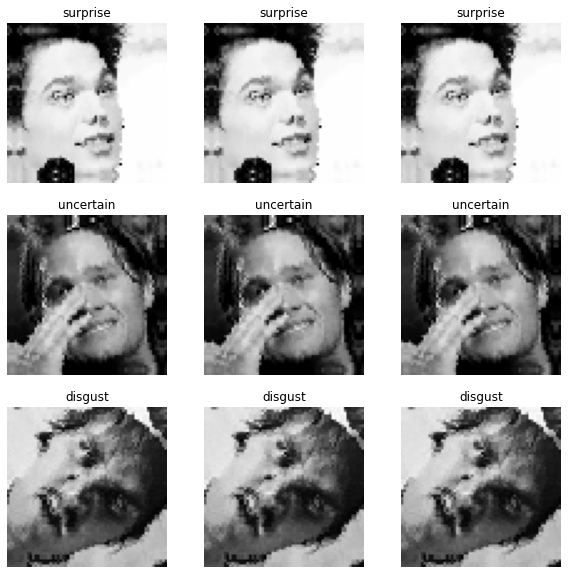

In [21]:
# визулизация полученного набора
image_batch, label_batch = iter(train_ds).get_next()

plt.figure(figsize=(10, 10))
for i in range(3): 
    for j in range(3):
        ax = plt.subplot(3, 3, i + j + 2*i + 1)
        ax.imshow((image_batch[i,j,:,:,].numpy().reshape((64,64))*255).astype("uint8"), cmap='gray')
        label = tf.argmax(label_batch[i]).numpy()
        ax.set_title(emotion_mapping[label])
        plt.axis("off")

In [22]:
# загрузка библиотек для создания нейронной сети
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [23]:
# функция построения DCNN
def build_dcnn(input_shape, show_arch=True):
    """
    Это глубокая сверточная нейронная сеть (DCNN). Для обобщения я использовал отсев через равные промежутки.
     Я использовал `ELU` в качестве активации, потому что это позволяет избежать проблемы умирания relu, но также работает лучше по сравнению с LeakyRelu.
     по крайней мере в этом случае. Используется инициализатор ядра `he_normal`, поскольку он подходит для ELU. BatchNormalization также используется для улучшения
     результатов.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.25, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.25, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.3, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_9'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_10'))
    
    net.add(Dropout(0.3, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [24]:
# функция построения модели
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [25]:
# создание папки модели и имени файла для записи весов во время обучения
path = Path('model_LSTM')
path.mkdir(exist_ok=True, parents=True) # папка создается на диске вместе с "родителями"
assert path.exists()
cpt_filename = 'best_checkpoint.hdf5'  
cpt_path = str(path / cpt_filename)

In [26]:
# обратный вызов для сохранения весов модели
checkpoint = ModelCheckpoint(cpt_path,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True,
                            save_freq='epoch'
                            )

In [27]:
# уменьшение скорости обучения, когда метрика перестала улучшаться
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

# обратные вызовы
callbacks = [checkpoint,
             PlotLossesCallback(),
            lr_scheduler
            ]

In [28]:
# создание и настройка модели для обучения
INPUT_SHAPE = (3, IMAGE_SIZE, IMAGE_SIZE, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=N_CLASSES)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['categorical_accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 3, 512)           4691904   
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 3, 256)           656384    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

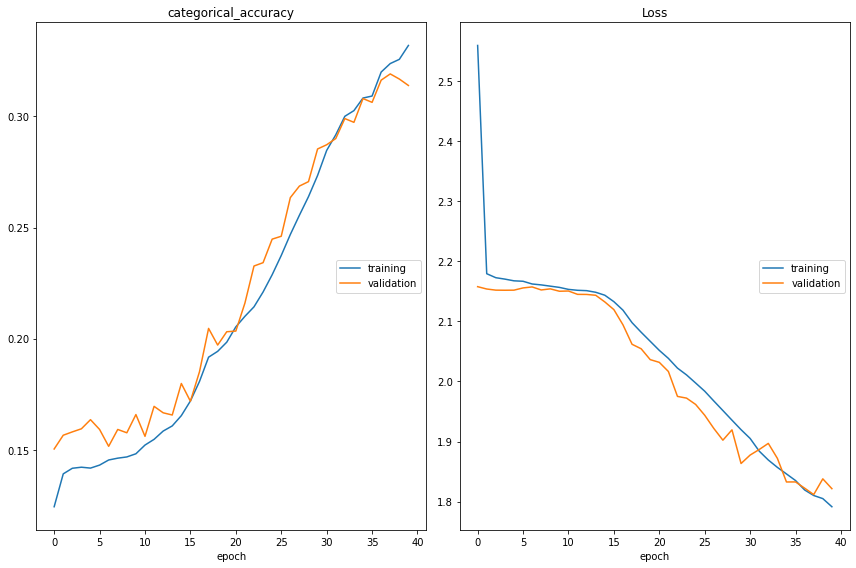

categorical_accuracy
	training         	 (min:    0.124, max:    0.332, cur:    0.332)
	validation       	 (min:    0.150, max:    0.319, cur:    0.314)
Loss
	training         	 (min:    1.791, max:    2.560, cur:    1.791)
	validation       	 (min:    1.812, max:    2.158, cur:    1.821)


In [ ]:
# обучение модели
EPOCHS = 40

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds,
                    callbacks=callbacks,
                    use_multiprocessing=True
                    )

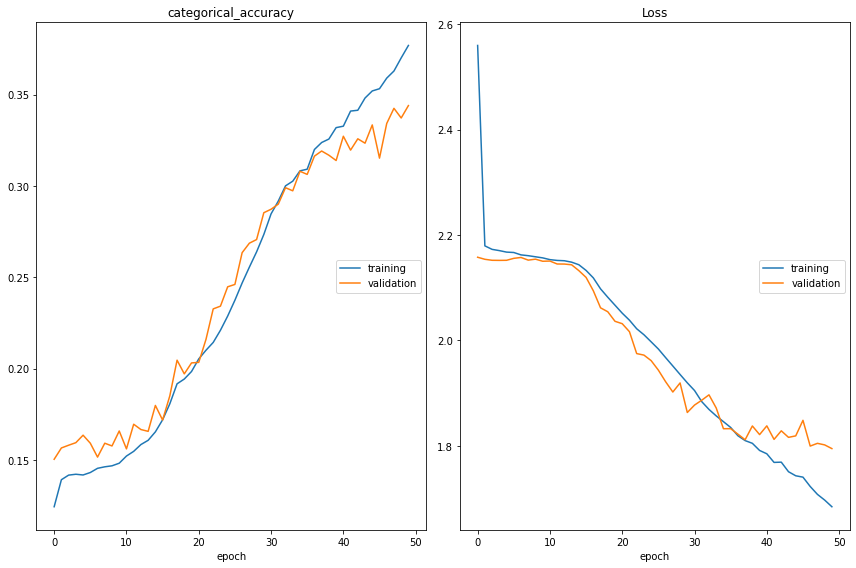

categorical_accuracy
	training         	 (min:    0.124, max:    0.377, cur:    0.377)
	validation       	 (min:    0.150, max:    0.344, cur:    0.344)
Loss
	training         	 (min:    1.685, max:    2.560, cur:    1.685)
	validation       	 (min:    1.795, max:    2.158, cur:    1.795)


In [ ]:
EPOCHS = 50

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds,
                    initial_epoch=40,
                    callbacks=callbacks,
                    use_multiprocessing=True
                    )

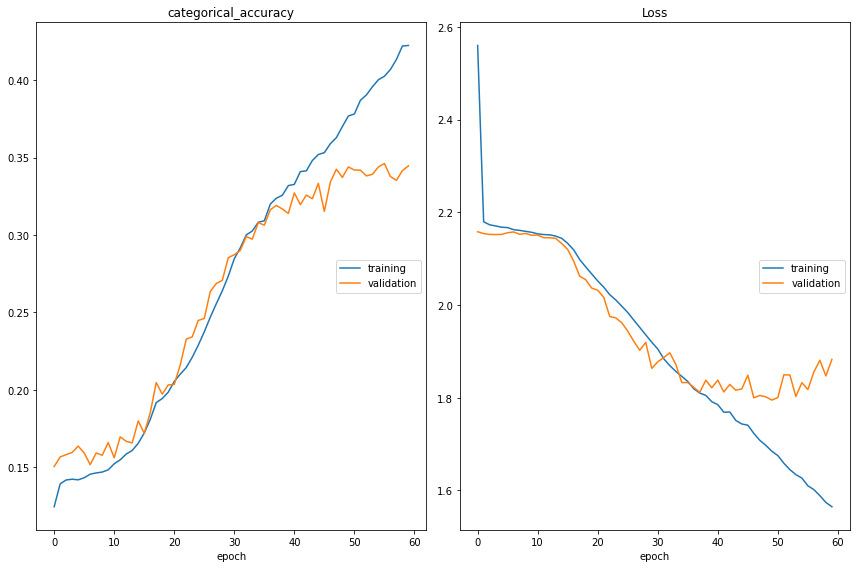

categorical_accuracy
	training         	 (min:    0.124, max:    0.422, cur:    0.422)
	validation       	 (min:    0.150, max:    0.346, cur:    0.345)
Loss
	training         	 (min:    1.565, max:    2.560, cur:    1.565)
	validation       	 (min:    1.795, max:    2.158, cur:    1.882)


In [ ]:
EPOCHS = 60

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds,
                    initial_epoch=50,
                    callbacks=callbacks,
                    use_multiprocessing=True
                    )

In [29]:
# загрузка весов модели с лучшим показателем
model.load_weights('model_LSTM/best_checkpoint.hdf5')

In [30]:
# значение потерь и значения метрики для модели в тестовом режиме
model.evaluate(val_ds)

313/313 [==============================] - 1735s 6s/step - loss: 1.7949 - categorical_accuracy: 0.3440


[1.794878602027893, 0.34399041533470154]

In [ ]:
# запись конфигурации модели
model_json = model.to_json()
with open("model_LSTM/model.json","w") as json_file:
    json_file.write(model_json)

In [31]:
# функция препроцессинга изображения для теста
def preprocess(img):  
    x = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    x = x / 255
    x_3 = np.stack((x, x, x))
    x = np.expand_dims(x_3, axis=0)
    
    return x

1/1 [==============================] - 0s 21ms/step


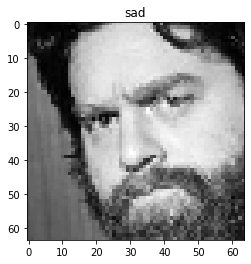

In [33]:
# тестирование модели на случайном изображении
rng = np.random.default_rng()
n = rng.integers(5000, size=1)[0]
img = tf.keras.preprocessing.image.load_img('test_kaggle/' + str(n) + '.jpg',
                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                              color_mode="grayscale"
                             )
predicted = model.predict(preprocess(img))
emotion = emotion_mapping[np.argmax(predicted)]
plt.title(emotion)
plt.imshow(img, cmap='gray')
plt.show()

In [34]:
# определение времени инференса сети
%%timeit 
#-n 10 -r 10

model.predict(preprocess(img))

1/1 [==============================] - 0s 17ms/step
48.5 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# создание списка для структруированного по заданию итогового csv-файла из файла 
def load_list_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

my_list = load_list_from_file('test_list.txt')

In [ ]:
# запись итогового csv-файла
with open('submission_LSTM.csv', 'w') as f:
    fieldnames = ['image_path', 'emotion']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for name in my_list:
        img = tf.keras.preprocessing.image.load_img('test_kaggle/'+ name,
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    grayscale = True,
                                                    color_mode="grayscale"
                                                   )
        predicted_arr = model.predict(preprocess(img))
        predicted = emotion_mapping[np.argmax(predicted_arr)]
        writer.writerow({'image_path': name.replace('test_kaggle/', ''), 'emotion': predicted})

### Оценки Kaggle

Score: 0.368

Public score:   0.3452